**Backgroud**

The Gaussian Mixture model, is a probalistic model that assumes all data points are generated from mixture of several Gaussian distribution with unknown parameters

Let the known variable be defined  as $x$ and the unknown label as $y$. We make two assumptions:
    The prior distribution $p(y)$ is a binomial
    $p(x|y)$ exist in each cluster

We perform the following steps perform a Guassian Mixture Model.
-   Initializing centriods.
-   Expectation Step.
-   Maximization Step.
-   Convergence step using maximum likihood.  

In [1]:
# Importing helper libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import logsumexp
from matplotlib import pyplot as plt
from sklearn import datasets

In [2]:
# Intializing random centriods
def get_random_psd(n):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())


def initialize_random_params():
    params = {'phi': np.random.uniform(0, 1),
              'mu0': np.random.normal(0, 1, size=(2,)),
              'mu1': np.random.normal(0, 1, size=(2,)),
              'sigma0': get_random_psd(2),
              'sigma1': get_random_psd(2)}
    return params

# Expectation step
def expectation_step(x, params):
    np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)])
    log_p_y_x = np.log([1-params["phi"], params["phi"]])[np.newaxis, ...] + \
                np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)]).T
    log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
    return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])


# Maximization step
def maximization_step(x, params):
    total_count = x.shape[0]
    _, heuristics = expectation_step(x, params)
    heuristic0 = heuristics[:, 0]
    heuristic1 = heuristics[:, 1]
    sum_heuristic1 = np.sum(heuristic1)
    sum_heuristic0 = np.sum(heuristic0)
    phi = (sum_heuristic1/total_count)
    mu0 = (heuristic0[..., np.newaxis].T.dot(x)/sum_heuristic0).flatten()
    mu1 = (heuristic1[..., np.newaxis].T.dot(x)/sum_heuristic1).flatten()
    diff0 = x - mu0
    sigma0 = diff0.T.dot(diff0 * heuristic0[..., np.newaxis]) / sum_heuristic0
    diff1 = x - mu1
    sigma1 = diff1.T.dot(diff1 * heuristic1[..., np.newaxis]) / sum_heuristic1
    params = {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}
    return params

def get_avg_log_likelihood(x, params):
    loglikelihood, _ = expectation_step(x, params)
    return np.mean(loglikelihood)


def run_em(x, params):
    avg_loglikelihoods = []
    while True:
        avg_loglikelihood = get_avg_log_likelihood(x, params)
        avg_loglikelihoods.append(avg_loglikelihood)
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001:
            break
        params = maximization_step(X, params)
    print("\tphi: %s\n \
            \tmu_0: %s\n \
            \tmu_1: %s\n \
            \tsigma_0: %s\n \
            \tsigma_1: %s"
               % (params['phi'], params['mu0'], params['mu1'], params['sigma0'], params['sigma1']))
    _, posterior = expectation_step(X, params)
    forecasts = np.argmax(posterior, axis=1)
    return forecasts, posterior, avg_loglikelihoods

### **Implementation**

In [3]:
data_unlabeled = pd.read_csv("unlabeled.csv")
# x_unlabeled = data_unlabeled[["x1", "x2"]].values
# data_unlabeled

X = np.array([data_unlabeled.x1.values, data_unlabeled.x2.values]).T

	phi: 0.9427400058755724
             	mu_0: [-1.04442138 -0.78826602]
             	mu_1: [0.24427049 0.13130461]
             	sigma_0: [[ 0.01009691 -0.00379262]
 [-0.00379262  0.0902857 ]]
             	sigma_1: [[1.60117876 1.29639702]
 [1.29639702 1.61280514]]
total steps:  25


/tmp/ipykernel_40125/3846973132.py:15: RuntimeWarning: divide by zero encountered in log
  np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
/tmp/ipykernel_40125/3846973132.py:18: RuntimeWarning: divide by zero encountered in log
  np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),


Text(0.5, 1.0, 'unsupervised log likelihoods')

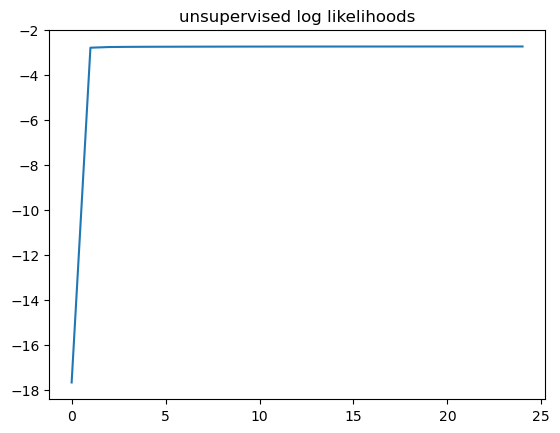

In [4]:
random_params = initialize_random_params()
unsupervised_forecastsforecasts, unsupervised_posterior, unsupervised_loglikelihoods = run_em(X, random_params)
print("total steps: ", len(unsupervised_loglikelihoods))
plt.plot(unsupervised_loglikelihoods)
plt.title("unsupervised log likelihoods")
# plt.savefig("unsupervised.png")
# plt.close()

In [5]:
# X = np.array([data_unlabeled.x1.values, data_unlabeled.x2.values]).T
params = initialize_random_params()
model = run_em(X, params)

	phi: 0.5225493180884968
             	mu_0: [-0.88069006 -0.90960563]
             	mu_1: [1.13092879 0.98161419]
             	sigma_0: [[0.39618021 0.46753439]
 [0.46753439 1.1098985 ]]
             	sigma_1: [[0.7673344  0.21725182]
 [0.21725182 0.28512441]]


	phi: 0.5240550384672212
             	mu_0: [-0.88337045 -0.91429705]
             	mu_1: [1.12758331 0.98044105]
             	sigma_0: [[0.39421274 0.46458538]
 [0.46458538 1.10538704]]
             	sigma_1: [[0.76987004 0.21838995]
 [0.21838995 0.28573078]]


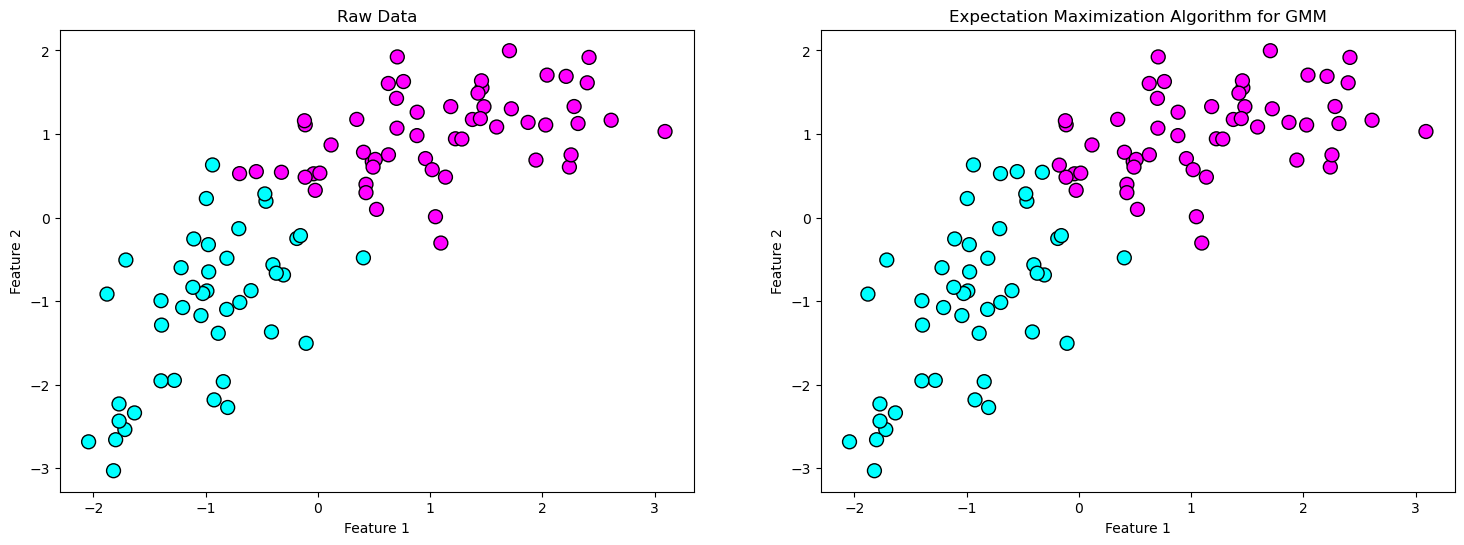

In [6]:
np.random.seed(0)

params = initialize_random_params()
model = run_em(X, params)


fa = plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.scatter(X[:, 0],X[:, 1],c=data_unlabeled.y, cmap=plt.cm.cool, s = 100,  marker='o', edgecolor='black')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Raw Data")



plt.subplot(1,2,2)
plt.scatter(X[:, 0],X[:, 1],c = model[0], cmap=plt.cm.cool, s = 100,  marker='o', edgecolor='black')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Expectation Maximization Algorithm for GMM")
plt.show()